# Transfer Learning with ResNet

**Note**: This notebook is designed to run on GPU runtime.

**[TLR-01]**

Install libraries including jax-resnet.

In [ ]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip install -q jax-resnet==0.0.4
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jax-resnet                    0.0.4
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[TLR-02]**

Import modules.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from functools import partial

import jax, flax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze

from tensorflow.keras.datasets import cifar10
from jax_resnet import pretrained_resnet, slice_variables, Sequential

plt.rcParams.update({'font.size': 12})

**[TLR-03]**

Download the CIFAR-10 dataset and store into NumPy arrays.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255
train_labels = np.eye(10)[np.array(train_labels).reshape(-1)]
test_labels = np.eye(10)[np.array(test_labels).reshape(-1)]

170508288/170498071 [==============================] - 13s 0us/step


**[TLR-04]**

Define a function to split the dataset into batches.

In [ ]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.array_split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

**[TLR-05]**

Show sample images for 10 categories.

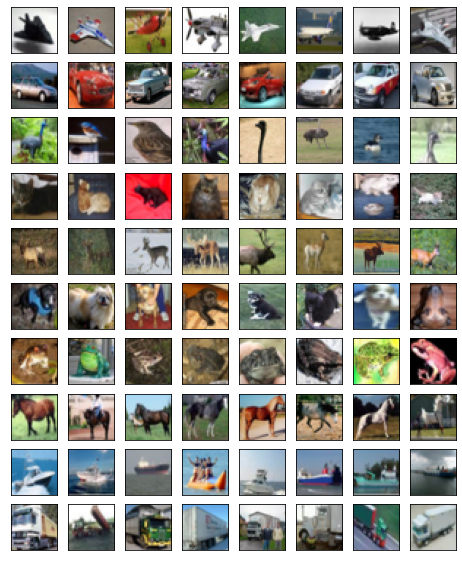

In [ ]:
fig = plt.figure(figsize=(8, 10))
c = 0
for i in range(10):
    for j in range(len(train_images)):
        if np.argmax(train_labels[j]) == i:
            c += 1
            subplot = fig.add_subplot(10, 8, c)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.imshow(train_images[j])
            if c % 8 == 0:
                break

**[TLR-06]**

Restore the backbone network and its parameter values.

In [ ]:
resnet_tmpl, resnet_variables = pretrained_resnet(18)
resnet_model = resnet_tmpl()
Backbone = Sequential(resnet_model.layers[:-1])
Backbone_variables = slice_variables(
    resnet_variables, 0, len(resnet_model.layers) - 1)

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**[TLR-07]**

Define the ResNet model with a new classification head.

In [ ]:
class ResNetModel(nn.Module):
    def setup(self):
        self.backbone = Backbone
        self.head = Head()

    def __call__(self, x, get_logits=False, eval=True):
        x = jax.image.resize(x, [x.shape[0], 128, 128, 3], 'bilinear')
        x = self.backbone(x)
        x = self.head(x, get_logits=get_logits, eval=eval)
        return x


class Head(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False, eval=True):
        x = nn.Dense(features=1024)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=eval)(x)
        x = nn.Dense(features=10)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

**[TLR-08]**

Generate initial parameter values.

**Note**: variables contains the following values.

- `variables['params']['backbone']` : Parameter values for the backbone network.
- `variables['params']['head']` :  Parameter values for the head.
- `variables['batch_stats']['backbone']` : batch normalization statistics.

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = ResNetModel().init(
    key1, train_images[0:1], {'dropout': random.PRNGKey(0)})

**[TLR-09]**

Copy parameter and statistics from the original network.

In [ ]:
new_variables = unfreeze(variables)
new_variables['batch_stats']['backbone'] = Backbone_variables['batch_stats']
new_variables['params']['backbone'] = Backbone_variables['params']
variables = freeze(new_variables)

**[TLR-10]**

Create a parameter mask.

In [ ]:
params_mask = unfreeze(
    jax.tree_util.tree_map(lambda x: False, variables['params']))
params_mask['head'] = unfreeze(
    jax.tree_util.tree_map(lambda x: True, variables['params']['head']))
params_mask = freeze(params_mask)

params_mask['head']

FrozenDict({
    Dense_0: {
        bias: True,
        kernel: True,
    },
    Dense_1: {
        bias: True,
        kernel: True,
    },
})

**[TLR-11]**

Create a TrainState object.

In [ ]:
class TrainState(train_state.TrainState):
    batch_stats: flax.core.FrozenDict
    epoch: int
    dropout_rng: type(random.PRNGKey(0))


zero_grads = optax.GradientTransformation(
    # init_fn(_)
    lambda x: (),
    # update_fn(updates, state, params=None)
    lambda updates, state, params: (jax.tree_map(jnp.zeros_like, updates), ()))

optimizer = optax.multi_transform(
    {True: optax.adam(learning_rate=0.001), False: zero_grads},
    params_mask)

key, key1 = random.split(key)

state = TrainState.create(
    apply_fn=ResNetModel().apply,
    params=variables['params'],
    batch_stats=variables['batch_stats'],
    tx=optimizer,
    dropout_rng=key1,
    epoch=0)

jax.tree_util.tree_map(lambda x: x.shape, state.params['head'])

FrozenDict({
    Dense_0: {
        bias: (1024,),
        kernel: (512, 1024),
    },
    Dense_1: {
        bias: (10,),
        kernel: (1024, 10),
    },
})

**[TLR-12]**

Save the initial checkpoint.

In [ ]:
checkpoints.save_checkpoint(
    ckpt_dir='./checkpoints/', prefix='ResNet_checkpoint_',
    target=state, step=state.epoch, overwrite=True)

'checkpoints/ResNet_checkpoint_0'

**[TLR-13]**

Define a loss function as the categorical cross entoropy.

In [ ]:
@partial(jax.jit, static_argnames=['eval'])
def loss_fn(params, state, inputs, labels, dropout_rng, eval):
    logits = state.apply_fn(
        {'params': params, 'batch_stats': state.batch_stats},
        inputs, eval=eval, get_logits=True, rngs={'dropout': dropout_rng})
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

**[TLR-14]**

Define a function to apply a single training step that returns a new training state.

In [ ]:
@partial(jax.jit, static_argnames=['eval'])
def train_step(state, inputs, labels, eval):
    if not eval:
        new_dropout_rng, dropout_rng = random.split(state.dropout_rng)
        (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
            state.params, state, inputs, labels, dropout_rng, eval)
        new_state = state.apply_gradients(
            grads=grads, dropout_rng=new_dropout_rng)
    else:
        loss, acc = loss_fn(
            state.params, state, inputs, labels, random.PRNGKey(0), eval)
        new_state = state

    return new_state, loss, acc

**[TLR-15]**

Define a function to apply the training steps for one epoch.

In [ ]:
def train_epoch(state, input_batched, label_batched, eval):
    loss_history, acc_history = [], []
    for inputs, labels in zip(input_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, labels, eval)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

**[TLR-16]**

Define a function to repeat the training steps for multiple epochs.

In [ ]:
def fit(state, ckpt_dir, prefix,
        train_inputs, train_labels, test_inputs, test_labels,
        epochs, batch_size):

    state = checkpoints.restore_checkpoint(
        ckpt_dir=ckpt_dir, prefix=prefix, target=state)

    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched = create_batches(test_labels, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(state.epoch + 1, state.epoch + 1 + epochs):
        # Training
        state, loss_train, acc_train = train_epoch(
            state, train_inputs_batched, train_labels_batched, eval=False)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        # Evaluation
        _ , loss_test, acc_test = train_epoch(
            state, test_inputs_batched, test_labels_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f} / '.format(
            epoch, loss_train, acc_train), end='', flush=True)
        print ('Loss(Test): {:.4f}, Accuracy(Test): {:.4f}'.format(
            loss_test, acc_test), flush=True)
        
        state = state.replace(epoch=state.epoch+1)
        checkpoints.save_checkpoint(
            ckpt_dir=ckpt_dir, prefix=prefix,
            target=state, step=state.epoch, overwrite=True, keep=5)
  
    history = {'loss_train': loss_history_train,
               'acc_train': acc_history_train,
               'loss_test': loss_history_test,
               'acc_test': acc_history_test}
  
    return state, history

**[TLR-17]**

Repeat the training steps for multiple epochs.

In [ ]:
%%time
ckpt_dir = './checkpoints/'
prefix = 'ResNet_checkpoint_'
state, history = fit(state, ckpt_dir, prefix,
                     train_images, train_labels, test_images, test_labels,
                     epochs=16, batch_size=64)

Epoch: 1, Loss: 0.9472, Accuracy: 0.6707 / Loss(Test): 0.7676, Accuracy(Test): 0.7388
Epoch: 2, Loss: 0.7770, Accuracy: 0.7269 / Loss(Test): 0.7247, Accuracy(Test): 0.7544
Epoch: 3, Loss: 0.7228, Accuracy: 0.7467 / Loss(Test): 0.7164, Accuracy(Test): 0.7570
Epoch: 4, Loss: 0.6878, Accuracy: 0.7557 / Loss(Test): 0.6923, Accuracy(Test): 0.7636
Epoch: 5, Loss: 0.6467, Accuracy: 0.7721 / Loss(Test): 0.6896, Accuracy(Test): 0.7656
Epoch: 6, Loss: 0.6209, Accuracy: 0.7802 / Loss(Test): 0.6882, Accuracy(Test): 0.7678
Epoch: 7, Loss: 0.5956, Accuracy: 0.7902 / Loss(Test): 0.6827, Accuracy(Test): 0.7714
Epoch: 8, Loss: 0.5676, Accuracy: 0.7988 / Loss(Test): 0.6729, Accuracy(Test): 0.7730
Epoch: 9, Loss: 0.5481, Accuracy: 0.8051 / Loss(Test): 0.6837, Accuracy(Test): 0.7719
Epoch: 10, Loss: 0.5248, Accuracy: 0.8147 / Loss(Test): 0.6848, Accuracy(Test): 0.7726
Epoch: 11, Loss: 0.5072, Accuracy: 0.8193 / Loss(Test): 0.6958, Accuracy(Test): 0.7739
Epoch: 12, Loss: 0.4847, Accuracy: 0.8275 / Loss(Tes

**[TLR-18]**

Plot a chart to compare the accuracy and loss for training and test datasets.

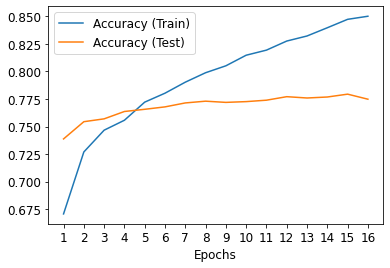

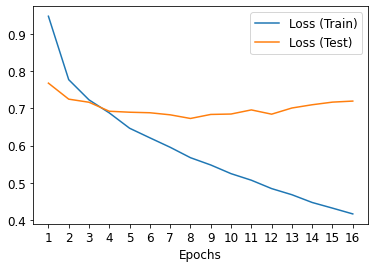

In [ ]:
df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

**[TLR-19]**

List the checkpoint files.

In [ ]:
!ls -lh ./checkpoints/

total 245M
-rw-r--r-- 1 root root 49M Oct  6 01:13 ResNet_checkpoint_12
-rw-r--r-- 1 root root 49M Oct  6 01:13 ResNet_checkpoint_13
-rw-r--r-- 1 root root 49M Oct  6 01:14 ResNet_checkpoint_14
-rw-r--r-- 1 root root 49M Oct  6 01:14 ResNet_checkpoint_15
-rw-r--r-- 1 root root 49M Oct  6 01:14 ResNet_checkpoint_16


**[TLR-20]**

Mount Google Drive content.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**[TLR-21]**

Save a TrainState checkpoint file.

In [ ]:
checkpoints.save_checkpoint(
    ckpt_dir='/content/gdrive/My Drive/checkpoints/',
    prefix='ResNet_checkpoint_',
    target=state, step=state.epoch, overwrite=True)

'/content/gdrive/My Drive/checkpoints/ResNet_checkpoint_16'

**[TLR-22]**

Download sample images.

In [ ]:
%%bash
curl -LO https://github.com/enakai00/colab_jaxbook/raw/main/Chapter05/imagenet-sample-images.zip
unzip -o imagenet-sample-images.zip

Archive:  imagenet-sample-images.zip
  inflating: imagenet-sample-images/n02423022_gazelle.JPEG  
  inflating: imagenet-sample-images/n01601694_water_ouzel.JPEG  
  inflating: imagenet-sample-images/n01644900_tailed_frog.JPEG  
  inflating: imagenet-sample-images/n02085936_Maltese_dog.JPEG  
  inflating: imagenet-sample-images/n02391049_zebra.JPEG  
  inflating: imagenet-sample-images/n04037443_racer.JPEG  
  inflating: imagenet-sample-images/n04467665_trailer_truck.JPEG  
  inflating: imagenet-sample-images/n03947888_pirate.JPEG  
  inflating: imagenet-sample-images/n02690373_airliner.JPEG  
  inflating: imagenet-sample-images/n02123394_Persian_cat.JPEG  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1051k  100 1051k    0     0  1294k      0 --:--:-- --:--:-- --:--:-- 1294k


**[TLR-23]**

Show prediction results for sample images.

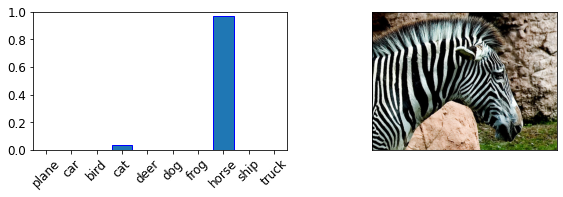

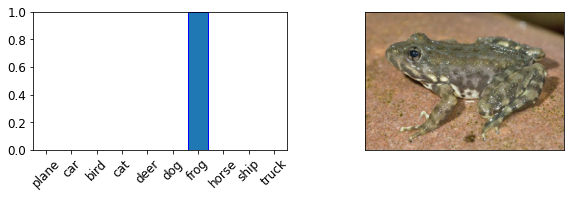

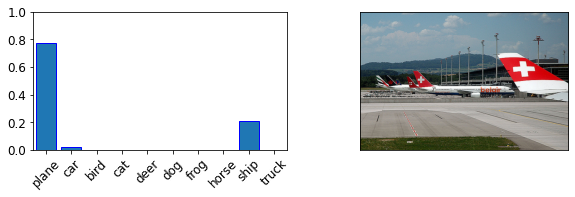

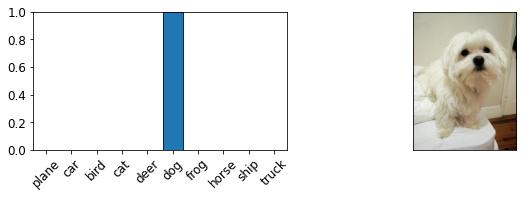

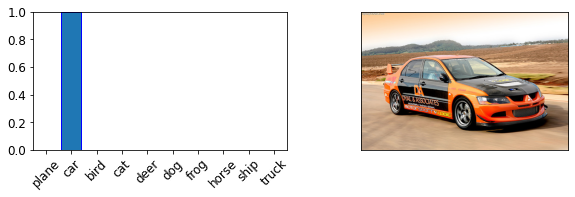

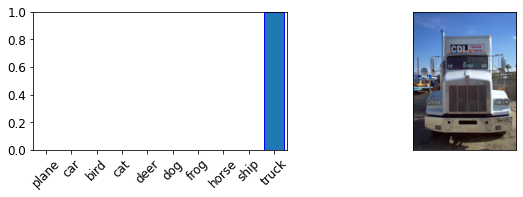

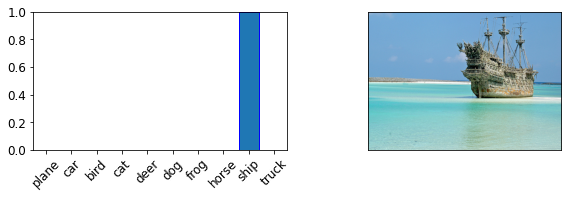

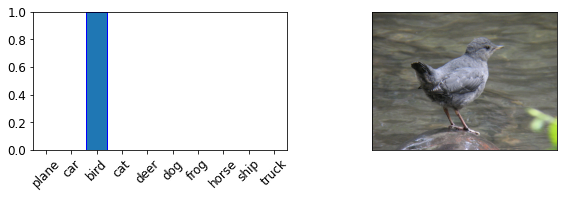

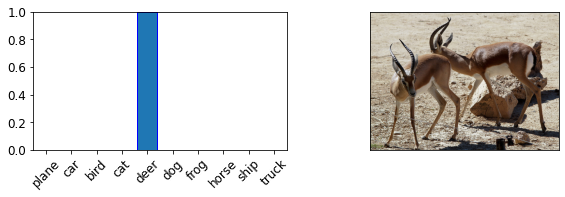

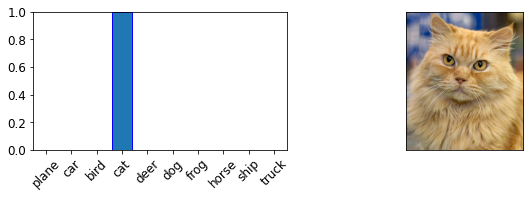

In [ ]:
import os
from matplotlib import image

basedir = './imagenet-sample-images/'
label_text = ['plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
files = os.listdir('./imagenet-sample-images/')
file_num = len(files)

for c, image_file in enumerate(files):
    img = image.imread(basedir + image_file)
    img = img.astype('float32') / 255
    prediction_vals = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        jnp.asarray([img]))
    prediction_vals = jax.device_get(prediction_vals[0])

    fig = plt.figure(figsize=(10, file_num*3))
    subplot = fig.add_subplot(file_num, 2, c*2+1)
    subplot.set_xticks(range(10))
    subplot.set_xlim([-0.5, 9.5])
    subplot.set_ylim([0, 1])
    subplot.bar(range(10), prediction_vals, align='center', edgecolor='b')
    subplot.set_xticklabels(label_text, rotation=45)

    subplot = fig.add_subplot(file_num, 2, c*2+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img)